## ДЗ по поиску

Привет! Вам надо реализивать поисковик на базе вопросов-ответов с сайта [pravoved.ru](https://pravoved.ru/questions-archive/).        
Поиск должен работать на трех технологиях:       
1. обратном индексе     
2. word2vec         
3. doc2vec      

Вы должны понять, какой метод и при каких условиях эксперимента на этом корпусе работает лучше.          
Для измерения качества поиска найдите точность (accuracy) выпадания правильного ответа на конкретный вопрос (в этой базе у каждого вопроса есть только один правильный ответ). Точность нужно измерить для всей базы.    
При этом давайте считать, что выпал правильный ответ, если он попал в **топ-5** поисковой выдачи.

> Сделайте ваш поиск максимально качественным, чтобы значение точности стремилось к 1.     
Для этого можно поэкспериментировать со следующим:       
- модель word2vec (можно брать любую из опен сорса или обучить свою)
- способ получения вектора документа через word2vec: простое среднее арифметическое или взвешивать каждый вектор в соответствии с его tf-idf      
- количество эпох у doc2vec (начинайте от 100)
- предобработка документов для обучения doc2vec (удалять / не удалять стоп-слова)
- блендинг методов поиска: соединить результаты обратного индекса и w2v, или (что проще) w2v и d2v

На это задание отведем 10 дней. Дэдлайн сдачи до полуночи 12.10.

In [1]:
import pickle

with open('qa_corpus.pkl', 'rb') as file:
    qa_corpus = pickle.load(file)

Всего в корпусе 1384 пары вопрос-ответ

In [2]:
len(qa_corpus)

1384

Сохраняю ответы в отдельные файлы

In [5]:
for index, item in enumerate(qa_corpus):
    with open('/Users/Stoneberry/Desktop/Uni/Прога/4 курс/Поиск/лекции/qa_data/' + str(index) + '.txt', 'w', encoding='utf-8') as f:
        f.write(item[1])

Первый элемент блока это вопрос, второй - ответ на него

In [6]:
qa_corpus[0]

['\nДобрый день.Мой сын гражданин Украины (ДНР),имеет вид на жительство в Р.Ф., кот.получил проживая с 2014 г. в Нижегородской области.В 2017г. переехал на постоянное место жительство в г.Ростов.Официально трудоустроился на одно из промышл.предприятий г.Ростова.Оформил временную регистрацию в Ростове.В УФМС предупредили,что по истечении 90 дней он должен либо постоянно прописаться либо покинуть территорию России.Прошу проконсультировать как быть дальше.(Вернуться домой в Донецк,но здесь идет война,работы нет.В Ростове он работает по специальности.Он инженер машиностроитель.)Временная прописка до 15 марта.  Если он сможет приобрести какую либо недвижимость,как долго будет решаться вопрос о его постоянной прописке в Ростове.Как в этом случае будет решаться вопрос с видом на жительство в Ростове? Не получится ли ,что приобретя квартиру,он не успеет в ней прописаться до окончании срока временной регистрации. С уважением Людмила Евгеньевна.\n',
 'Добрый вечер!Из Вашего вопроса вообще ничего

In [256]:
from pymystem3 import Mystem
import gensim
from judicial_splitter import split_paragraph, get_sentences
import string
import re
import json
import os
from gensim import matutils
import numpy as np 
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
import random
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings('ignore')
mystem = Mystem()

In [8]:
russian_stopwords = set(stopwords.words('russian'))

### Word2vec

In [9]:
model = Word2Vec.load('/Users/Stoneberry/Desktop/Uni/Прога/4 курс/Поиск/araneum_none_fasttextcbow_300_5_2018/araneum_none_fasttextcbow_300_5_2018.model')

In [52]:
def preprocessing(input_text, stopwords={}, del_stopwords=True, del_digit=True):
    
    words = [x.lower().strip(string.punctuation+'»«–…') for x in word_tokenize(input_text)]
    lemmas = [mystem.lemmatize(x)[0] for x in words if x]
    lemmas_arr = []
    for lemma in lemmas:
        if del_stopwords:
            if lemma in stopwords:
                continue
        if del_digit:
            if lemma.isdigit():
                continue
        lemmas_arr.append(lemma)
    return lemmas_arr

In [76]:
def get_w2v_vectors(lemmas, model): 
    #lemmas = preprocessing(query)
    lemmas_vectors = []
    for lemma in lemmas:
        try:
            lemmas_vectors.append(model.wv[lemma])
        except:
            None
    if lemmas_vectors:
        doc_vec = sum(lemmas_vectors)
        normalized_vec = matutils.unitvec(doc_vec)
        return list(normalized_vec)
    else: 
        return [0] * 300

Я не понимаю, почему это не работает

In [69]:
def get_w2v_vectors2(text, model):
    """Получает вектор документа"""

    vec = 0
    lenght = 0
    
    for word in text:
        try: 
            vec += model.wv[word]
            lenght += 1
        except: None
    
    if lenght != 0:
        return vec / lenght
    return [0] * 300

In [19]:
def splitting(main_dir, stopwords={}, del_stop=True):
    for root, dirs, files in os.walk(main_dir):
        for name in files:
            if not '.DS_Store' in name:
                with open(os.path.join(root, name), 'r', encoding='utf-8') as f:
                    text = f.read() 
                    parts = split_paragraph(get_sentences(text), 4)
                    for part in parts:
                        part_proc = preprocessing(part, stopwords, del_stopwords=del_stop, del_digit=True)
                        yield (part_proc, name, part)

In [199]:
def save_w2v_base(main_dir, model, stopwords={}, del_stop=True):
    """Индексирует всю базу для поиска через word2vec"""

    all_data = []

    for part in splitting(main_dir, stopwords=stopwords, del_stop=del_stop):
        vec_info = {}
        vec_info['id'] = part[1]
        vec_info['text'] = part[2]
        vec_info['vec'] = get_w2v_vectors(part[0], model)
        all_data.append(vec_info)

    return all_data #json.dumps(all_data)

In [200]:
def similarity(v1, v2):
    v1_norm = matutils.unitvec(np.array(v1))
    v2_norm = matutils.unitvec(np.array(v2))
    return np.dot(v1_norm, v2_norm)


def similarity(vec1, vec2):
    return np.dot(vec1, vec2)


def culc_sim_score(data1, vec):
    
    """
    соединяю параграфы в текст
    """
    
    answer = defaultdict(list) # id : [text, sim_score]
    
    for part in data1:
        obj = answer[part['id']]
        sim = similarity(part['vec'], vec)
        if obj == []:
            obj.append('')
            obj.append(float('-inf'))
        obj[0] += part['text'] + ' '
        if sim > obj[1]:
            obj[1] = sim
    return answer

In [30]:
def search_w2v(string, model, data1, stopwords={}, amount=10, del_stop=True):
    
    if not isinstance(string, str):
        raise ValueError('enter correct data')
    
    words = preprocessing(string, stopwords=stopwords, del_stopwords=del_stop, del_digit=True)
    vec = get_w2v_vectors(words, model)
    answer = culc_sim_score(data1, vec)
    
    for index, ans in enumerate(sorted(answer.items(), key=lambda x: x[1][1], reverse=True)):
        if index >= amount: break
        yield (ans[0], ans[1][0], ans[1][1])

In [77]:
main_dir = '/Users/Stoneberry/Desktop/Uni/Прога/4 курс/Поиск/лекции/qa_data/'
data1 = save_w2v_base(main_dir, model, stopwords=russian_stopwords)

Testing

In [137]:
pred = 0
for index, qa in enumerate(qa_corpus):
    idx = str(index) + '.txt'
    for i in search_w2v(qa[0], model, data1, stopwords=russian_stopwords, del_stop=True, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)


0.2774566473988439

In [93]:
for i in search_w2v(qa_corpus[35][0], model, data1, stopwords=russian_stopwords, amount=10):
    print(i[0], i[2])

35.txt 0.766294
315.txt 0.745872
402.txt 0.7099507
622.txt 0.68759716
643.txt 0.63410246
817.txt 0.6237143
1307.txt 0.61546665
647.txt 0.6010889
1358.txt 0.6004466
263.txt 0.60017496


### Tf

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
tfidf = TfidfVectorizer(ngram_range = (1,1), stop_words=russian_stopwords)
tfidf.fit([i[1] for i in qa_corpus])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'тогда', 'свою', 'если', 'ж', 'этой', 'ей', 'после', 'хоть', 'опять', 'том', 'ни', 'не', 'все', 'даже', 'что', 'другой', 'его', 'бы', 'к', 'сам', 'нас', 'моя', 'тебя', 'им', 'ведь', 'вас', 'она', 'когда', 'три', 'на', 'хорошо', 'раз', 'потому', 'в', 'тут', 'здесь', 'я', 'нибудь', 'ее', '...оже', 'сейчас', 'их', 'при', 'будет', 'куда', 'этом', 'него', 'вам', 'ну', 'а', 'они', 'чтоб', 'во'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [165]:
def get_w2v_vectors_tf(lemmas, model, tfidf): 
    
    vocab = tfidf.vocabulary_
    arr = tfidf.transform([' '.join(lemmas)]).toarray()[0]
    weight = 1
    lemmas_vectors = []
    all_weight = 0

    for lemma in lemmas:
        if lemma in vocab:
            weight = arr[vocab[lemma]]
        try:
            lemmas_vectors.append(model.wv[lemma] * weight)
            all_weight += weight
        except:
            None
    if lemmas_vectors:
        doc_vec = sum(lemmas_vectors) #/ all_weight
        #doc_vec = list(matutils.unitvec(doc_vec))
        return doc_vec
    else: 
        return [0] * 300

In [106]:
def search_w2v_tf(string, model, data1, stopwords={}, amount=10, del_stop=True):
    
    if not isinstance(string, str):
        raise ValueError('enter correct data')
        
    global tfidf
    words = preprocessing(string, stopwords=stopwords, del_stopwords=del_stop, del_digit=True)
    vec = get_w2v_vectors_tf(words, model, tfidf)
    answer = culc_sim_score(data1, vec)
    
    for index, ans in enumerate(sorted(answer.items(), key=lambda x: x[1][1],  reverse=True)):
        if index >= amount: break
        yield (ans[0], ans[1][0], ans[1][1])

Testing

In [166]:
pred = 0
for index, qa in enumerate(qa_corpus):
    idx = str(index) + '.txt'
    for i in search_w2v_tf(qa[0], model, data1, stopwords=russian_stopwords, del_stop=True, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)


0.25072254335260113

Расчет среднего арифметического оказался лучше

In [167]:
for i in search_w2v_tf(qa_corpus[35][0], model, data1, stopwords=russian_stopwords, amount=10):
    print(i[0], i[2])

35.txt 3.0969675
315.txt 3.0812178
402.txt 2.9510856
622.txt 2.852767
643.txt 2.4845889
303.txt 2.4650326
1259.txt 2.4629474
817.txt 2.4600716
1307.txt 2.4401164
568.txt 2.4354715


### Doc2vec

Количество эпох у doc2vec (начинайте от 100)

In [112]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from math import log

In [203]:
def tagged_data_creator(main_dir, stopwords={}, del_stop=False):
    
    tagged_data = []
    i = 0
    for part in splitting(main_dir, stopwords=stopwords, del_stop=del_stop):
        tagged_data.append(TaggedDocument(words=part[0], tags=[i]))
        #print('Complited: ' + part[1])
        i += 1
    return tagged_data   

In [114]:
def train_doc2vec(tagged_data, epo=100):
    
    model = Doc2Vec(vector_size=100, min_count=5, alpha=0.025, 
                min_alpha=0.025, epochs=epo, workers=2, dm=1)
    
    print('building vocabulary')
    model.build_vocab(tagged_data)
    print('starting training...')
    model.random.seed(42)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    print('model is trained')
    return model

In [115]:
def get_d2v_vectors(model, text):
    """Получает вектор документа"""
    return model.infer_vector(text)
    

def save_d2v_base(main_dir, model, stopwords={}, del_stop=False):
    """Индексирует всю базу для поиска через doc2vec"""
    
    all_data = []

    for part in splitting(main_dir, stopwords=stopwords, del_stop=del_stop):
        vec_info = {}
        vec_info['id'] = part[1]
        vec_info['text'] = part[2]
        vec_info['vec'] = get_d2v_vectors(model, part[0])
        all_data.append(vec_info)
    return all_data #json.dumps(all_data)

In [116]:
def search_d2v(string, model, data2, stopwords={}, del_stop=False, amount=10):
    
    if not isinstance(string, str):
        raise ValueError('enter correct data')
    
    words = preprocessing(string, stopwords=stopwords, del_stopwords=del_stop, del_digit=True)
    vec = get_d2v_vectors(model, words)
    answer = culc_sim_score(data2, vec)
    
    for index, ans in enumerate(sorted(answer.items(), key=lambda x: x[1][1], reverse=True)):
        if index >= amount: break
        yield (ans[0], ans[1][0], ans[1][1])

In [117]:
dir2 = '/Users/Stoneberry/Desktop/Uni/Прога/4 курс/Поиск/лекции/train'
model_data = tagged_data_creator(dir2, stopwords=russian_stopwords)

Testing

In [205]:
res = []

In [242]:
for epo in range(100, 500, 100):

    print('Starting: ' + str(epo))
    my_model = train_doc2vec(model_data, epo=epo)
    data2 = save_d2v_base(main_dir, my_model, stopwords=russian_stopwords, del_stop=True)

    pred = 0
    for index, qa in enumerate(qa_corpus):
        idx = str(index) + '.txt'
        for i in search_d2v(qa[0], my_model, data2, stopwords=russian_stopwords, del_stop=True, amount=5):
            if i[0] == idx:
                pred += 1
    res.append(pred / len(qa_corpus))

Starting: 100
building vocabulary
starting training...
model is trained
Starting: 200
building vocabulary
starting training...
model is trained
Starting: 300
building vocabulary
starting training...
model is trained
Starting: 400
building vocabulary
starting training...
model is trained


In [244]:
import matplotlib.pyplot as plt

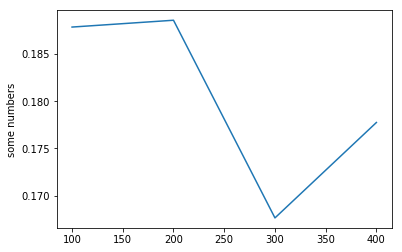

In [247]:
plt.plot(list(range(100, 500, 100)), res)
plt.ylabel('some numbers')
plt.show()

Лучший результат на 200 эпохах

Предобработка документов для обучения doc2vec (удалять / не удалять стоп-слова)

Не удаляя

In [134]:
my_model = train_doc2vec(model_data, epo=100)
data2 = save_d2v_base(main_dir, my_model, stopwords=russian_stopwords, del_stop=False)

pred = 0
for index, qa in enumerate(qa_corpus):
    idx = str(index) + '.txt'
    for i in search_d2v(qa[0], my_model, data2, stopwords=russian_stopwords, del_stop=False, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)

building vocabulary
starting training...
model is trained


0.1791907514450867

Удаляя

In [132]:
data2 = save_d2v_base(main_dir, my_model, stopwords=russian_stopwords, del_stop=True)
pred = 0

for index, qa in enumerate(qa_corpus):
    idx = str(index) + '.txt'
    for i in search_d2v(qa[0], my_model, data2, stopwords=russian_stopwords, del_stop=True, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)

0.1893063583815029

Как видно, удаляя стоп слова, accuracy выше

### d2v & w2v

Блендинг методов поиска: соединить результаты обратного индекса и w2v, или (что проще) w2v и d2v

In [179]:
def merging(w2v, d2v, all_):
    
    ans = {}

    for item in all_:

        if item in w2v: 
            it_w = w2v[item]
        else: it_w = 0

        if item in d2v: 
            it_d = d2v[item]
        else: it_d = 0
        
        ans[item] = (it_w * 0.7 + it_d * 0.3) / 2
    return ans

In [182]:
def serach_w2_d2(string, model, my_model, data1, data2, stopwords={}, del_stop=False, amount=10):

    w2v = {i[0]:i[2] for i in search_w2v(string, model, data1, stopwords=stopwords, del_stop=del_stop, amount=amount)}
    d2v = {i[0]:i[2] for i in search_d2v(string, my_model, data2, stopwords=stopwords, del_stop=del_stop, amount=amount)}
    all_ = set(w2v) | set(d2v)
    ans = merging(w2v, d2v, all_)
    return sorted(ans.items(), reverse=True, key=lambda x: x[1])


In [185]:
pred = 0

for index, qa in enumerate(qa_corpus):
    idx = str(index) + '.txt'
    for i in serach_w2_d2(qa[0], model, my_model, data1, data2,del_stop=True, stopwords=russian_stopwords, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)

0.3179190751445087

Использование двух моделей дает лучший результат

##### Okapi

In [223]:
def counter(main_dir, del_stop=True, stopwords={}):

    word_count = defaultdict(dict) # word : {id, count}
    id_text = defaultdict(list) # id : [len, text]

    for root, dirs, files in os.walk(main_dir):
        for name in files:
            if not '.DS_Store' in name:
                with open(os.path.join(root, name), 'r', encoding='utf-8') as f:
                    text = f.read() 
                    words = preprocessing(text, stopwords=stopwords, del_stopwords=del_stop, del_digit=True)
                    id_text[name] += [len(words), text]
                    prob = Counter(words)
                    for word in prob:
                        word_count[word][name] = prob[word]
                
    return word_count, id_text


def score_BM25(qf, dl, avgdl, k1, b, N, n):
    """
    Compute similarity score between search query and documents from collection
    :return: score

    qf - кол - во вхождений слова в документе
    dl - длина документа

    """

    tf = qf / dl
    idf = log(N - n + 0.5 / n + 0.5)
    a = (k1 + 1) * tf
    b = tf + k1*(1 - b + b*(dl / avgdl))

    return (a / b) * idf


def compute_sim(text, doc, id_text, word_count, N, stopwords={}, del_stop=True):
    """
    Compute similarity score between search query and documents from collection
    :return: score
    """

    if not isinstance(text, str):
        raise ValueError('enter correct data')
    if not isinstance(doc, str):
        raise ValueError('enter correct data')

    opr = [' ', '  ', '\t', '\n']
    k1 = 2.0
    b = 0.75
    avgdl = np.mean([i[0] for i in id_text.values()])

    ans = 0

    words = preprocessing(text, stopwords=stopwords, del_stopwords=del_stop, del_digit=True)

    for word in words:
        if word in word_count:
            if doc in word_count[word]:
                qf = word_count[word][doc]
            else:
                qf = 0
            dl = id_text[doc][0]
            n = len(word_count[word])
            ans += score_BM25(qf, dl, avgdl, k1, b, N, n)

    return ans


def get_search_result(text, id_text, word_count, stopwords={}, del_stop=True, amount=10):
    """
    Compute sim score between search query and all documents in collection
    Collect as pair (doc_id, score)
    :param query: input text
    :return: list of lists with (doc_id, score)
    """

    if not isinstance(text, str):
        raise ValueError

    arr = []
    N = len(id_text)
   
    for doc in id_text:
        arr.append((doc, id_text[doc][1], compute_sim(text, doc, id_text, word_count, N, stopwords=stopwords, del_stop=del_stop)))
    
    arr = sorted(arr, key=lambda x: x[2], reverse=True)
    
    return arr[:amount]

In [210]:
word_count, id_text = counter(main_dir, stopwords=russian_stopwords)

In [234]:
for i in get_search_result('приговор', id_text, word_count, stopwords=russian_stopwords, amount=5):
    print(i[0], i[2])

687.txt 3.55123096620198
329.txt 2.0828200173558153
1008.txt 1.5150265255600737
1176.txt 0.7071466707337445
89.txt 0.5485908282723401


Совмещение

In [208]:
def merging_all_3(w2v, d2v, okapi, all_):
    
    ans = {}

    for item in all_:

        if item in w2v: 
            it_w = w2v[item]
        else: it_w = 0

        if item in d2v: 
            it_d = d2v[item]
        else: it_d = 0
            
        if item in okapi:
            it_o = okapi[item]
        else: it_o = 0
        
        ans[item] = (((it_w * 0.8 + it_o * 0.2) / 2) * 0.7 + it_d * 0.3) / 2
    return ans

In [230]:
def serach_w2_d2_ok(string, model, my_model, data1, data2, word_count, id_text, stopwords={}, del_stop=False, amount=10):

    w2v = {i[0]:i[2] for i in search_w2v(string, model, data1, stopwords=stopwords, del_stop=del_stop, amount=amount)}
    d2v = {i[0]:i[2] for i in search_d2v(string, my_model, data2, stopwords=stopwords, del_stop=del_stop, amount=amount)}
    okapi = {i[0]:i[2] for i in get_search_result(string, id_text, word_count, stopwords=russian_stopwords, del_stop=del_stop, amount=amount)}
    all_ = set(w2v) | set(d2v) | set(okapi)
    ans = merging_all_3(w2v, d2v, okapi, all_)
    return sorted(ans.items(), reverse=True, key=lambda x: x[1])


In [257]:
pred = 0
l = 0
for index, qa in enumerate(qa_corpus):
    l += 1
    idx = str(index) + '.txt'
    for i in serach_w2_d2_ok(qa[0], model, my_model, data1, data2, word_count, id_text, del_stop=True, stopwords=russian_stopwords, amount=5):
        if i[0] == idx:
            pred += 1
pred / len(qa_corpus)

0.3865606936416185

Получается самый высокий результат